# Training Approaches and Training Performance

## 1. Single GPU (1 x GPU)

In [1]:
from fastai.vision.all import *
from timm import create_model
from fastai.vision.learner import _update_first_layer
from fastai.distributed import *
import os
from sklearn.model_selection import train_test_split
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 42
seed_everything(SEED)
torch.cuda.empty_cache()
import gc
gc.collect()
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('/home/jupyter/data/chexpert/chexpert.csv')
df = df.dropna(subset=['labels'])

bs = 64
epoch = 10
metrics=[accuracy_multi,  
         RocAucMulti(),
         PrecisionMulti(),
         RecallMulti(),     
         F1ScoreMulti()]

item_tfms=Resize(224, method='squish', pad_mode='zeros', resamples=(2, 0))
batch_tfms=[*aug_transforms(mult=1.0, do_flip=False, flip_vert=False, 
                            max_rotate=20.0, max_zoom=1.2, max_lighting=0.3, max_warp=0.2, 
                            p_affine=0.75, p_lighting=0.75, 
                            xtra_tfms=None, size=None, mode='bilinear', pad_mode='reflection', 
                            align_corners=True, batch=False, min_scale=1.0),
                            Normalize.from_stats(*imagenet_stats)]

dl = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
              get_x=ColReader('Path'),
              get_y=ColReader('labels', label_delim=','),
              splitter=RandomSplitter(seed = SEED),
              item_tfms=item_tfms,
              batch_tfms=batch_tfms
).dataloaders(df_train, bs=bs)

def create_body(arch, n_in=3, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained `arch` as determined by `cut`"
    model = arch(pretrained=pretrained)
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if   isinstance(cut, int):      return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or a function")

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

body = create_timm_body('densenetblur121d', pretrained=True)
nf = num_features_model(body)
head = create_head(nf, dl.c, concat_pool=True)
net = nn.Sequential(body, head)

learn = Learner(dl, net, metrics=metrics)

In [2]:
learn.fine_tune(epoch)

epoch,train_loss,valid_loss,accuracy_multi,roc_auc_score,precision_score,recall_score,f1_score,time
0,0.364975,0.362127,0.848030,0.621062,0.206667,0.158945,0.158359,18:00


epoch,train_loss,valid_loss,accuracy_multi,roc_auc_score,precision_score,recall_score,f1_score,time
0,0.335588,1.373421,0.859621,0.685621,0.283747,0.171413,0.174822,15:10
1,0.330780,0.320034,0.864580,0.710645,0.322161,0.179869,0.182671,15:14
2,0.320333,0.319258,0.870024,0.734617,0.327299,0.204798,0.211047,15:17
3,0.311938,0.309140,0.874392,0.756287,0.342670,0.211589,0.240348,15:15
4,0.300024,0.318654,0.875935,0.758685,0.332722,0.220366,0.249982,15:17
5,0.297472,0.302477,0.877811,0.768974,0.337943,0.244079,0.267641,15:14
6,0.293585,0.291502,0.880232,0.779494,0.345960,0.235397,0.266572,15:13
7,0.286634,0.296563,0.877402,0.781105,0.369196,0.223684,0.260615,15:12
8,0.287068,0.300737,0.881693,0.785706,0.491309,0.247628,0.279196,15:15
9,0.283682,0.309945,0.880916,0.785521,0.450668,0.248046,0.277634,15:24


## 2. Data parallel (4 x GPUs)

In [1]:
from fastai.vision.all import *
from timm import create_model
from fastai.vision.learner import _update_first_layer
from fastai.distributed import *
import os
from sklearn.model_selection import train_test_split
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 42
seed_everything(SEED)
torch.cuda.empty_cache()
import gc
gc.collect()
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('/home/jupyter/data/chexpert/chexpert.csv')
df = df.dropna(subset=['labels'])

bs = 64
epoch = 10
metrics=[accuracy_multi,  
         RocAucMulti(),
         PrecisionMulti(),
         RecallMulti(),     
         F1ScoreMulti()]

item_tfms=Resize(224, method='squish', pad_mode='zeros', resamples=(2, 0))
batch_tfms=[*aug_transforms(mult=1.0, do_flip=False, flip_vert=False, 
                            max_rotate=20.0, max_zoom=1.2, max_lighting=0.3, max_warp=0.2, 
                            p_affine=0.75, p_lighting=0.75, 
                            xtra_tfms=None, size=None, mode='bilinear', pad_mode='reflection', 
                            align_corners=True, batch=False, min_scale=1.0),
                            Normalize.from_stats(*imagenet_stats)]

dl = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
              get_x=ColReader('Path'),
              get_y=ColReader('labels', label_delim=','),
              splitter=RandomSplitter(seed = SEED),
              item_tfms=item_tfms,
              batch_tfms=batch_tfms
).dataloaders(df_train, bs=bs)

def create_body(arch, n_in=3, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained `arch` as determined by `cut`"
    model = arch(pretrained=pretrained)
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if   isinstance(cut, int):      return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or a function")

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

body = create_timm_body('densenetblur121d', pretrained=True)
nf = num_features_model(body)
head = create_head(nf, dl.c, concat_pool=True)
net = nn.Sequential(body, head)

learn = Learner(dl, net, metrics=metrics)

In [2]:
# Get number of GPUs
gpu = None
if torch.cuda.is_available():
    if gpu is not None: torch.cuda.set_device(gpu)
    n_gpu = torch.cuda.device_count()
else:
    n_gpu = None
if gpu is None and n_gpu is not None:
    ctx = learn.parallel_ctx
    with partial(ctx, gpu)():
        print(f"Training in {ctx.__name__} context on GPU {list(range(n_gpu))}")
        learn.fine_tune(epoch)
else:
    learn.fine_tune(epoch)

Training in parallel_ctx context on GPU [0, 1, 2, 3]


epoch,train_loss,valid_loss,accuracy_multi,roc_auc_score,precision_score,recall_score,f1_score,time
0,0.354241,1.775289,0.824917,0.552743,0.207595,0.106159,0.108019,14:48


epoch,train_loss,valid_loss,accuracy_multi,roc_auc_score,precision_score,recall_score,f1_score,time
0,0.325035,0.384501,0.862797,0.708870,0.290417,0.183053,0.191933,13:17
1,0.315641,0.511135,0.867180,0.711438,0.340071,0.190921,0.225021,13:19
2,0.310099,0.304432,0.872856,0.756933,0.368116,0.180605,0.223870,13:24
3,0.306194,0.302242,0.875009,0.761594,0.346970,0.203941,0.241985,13:25
4,0.298066,0.292521,0.879824,0.776521,0.377597,0.227905,0.261386,13:29
5,0.296153,0.305199,0.872605,0.766734,0.398134,0.220145,0.257148,13:34
6,0.291514,0.286819,0.882074,0.786717,0.438975,0.236671,0.273682,13:23
7,0.287478,0.287295,0.882149,0.789280,0.527162,0.238158,0.270215,13:43
8,0.286338,0.285042,0.883192,0.791354,0.536970,0.243020,0.279921,13:42
9,0.282835,0.283957,0.883633,0.792563,0.547039,0.251861,0.285845,13:40


In [3]:
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 112 x 112 
Conv2d                                    864        True      
ReLU                                                           
Conv2d                                    9216       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 112 x 112 
Conv2d                                    18432      True      
ReLU                                                           
MaxPool2d                                                      
BlurPool2d                                                     
ReLU                                                           
____________________________________________________________________________
                     64 x 128 x 56 x 56  
Conv2d                                    8192     

In [6]:
interp = Interpretation.from_learner(learn)

In [7]:
interp2 = ClassificationInterpretation.from_learner(learn)

In [10]:
interp2.most_confused(min_val=1)

[('cardiomegaly', 'atelectasis', 49496),
 ('atelectasis', 'cardiomegaly', 19741)]

,target,predicted,probabilities,loss
0,atelectasis;cardiomegaly;consolidation;edema;lung lesion;lung opacity;pneumothorax;support devices,pneumothorax;support devices,"TensorBase([0.1561, 0.0141, 0.0129, 0.0599, 0.0380, 0.0641, 0.0123, 0.0135, 0.3196,\n 0.2363, 0.0074, 0.0031, 0.5778, 0.5345])",1.450364589691162
1,cardiomegaly;fracture;lung lesion;lung opacity;pleural other,lung opacity;pleural effusion,"TensorBase([0.1049, 0.0202, 0.1114, 0.3434, 0.0198, 0.0316, 0.0074, 0.0245, 0.6293,\n 0.5842, 0.0069, 0.0494, 0.1381, 0.2069])",1.4259753227233887
2,cardiomegaly;fracture;pleural other;pneumonia;support devices,edema;lung opacity;support devices,"TensorBase([0.1050, 0.2433, 0.0231, 0.5049, 0.0466, 0.0565, 0.0190, 0.0141, 0.5310,\n 0.0698, 0.0034, 0.0192, 0.0067, 0.6384])",1.2322769165039062
3,cardiomegaly;consolidation;enlarged cardiomediastinum;lung lesion;lung opacity;pleural effusion,lung opacity,"TensorBase([0.1164, 0.0065, 0.0605, 0.0069, 0.0324, 0.0423, 0.0368, 0.0756, 0.5131,\n 0.3284, 0.0374, 0.0233, 0.4517, 0.4101])",1.2172374725341797
4,atelectasis;fracture;lung lesion;lung opacity;pneumonia;support devices,cardiomegaly;support devices,"TensorBase([0.1428, 0.5869, 0.0201, 0.1261, 0.0924, 0.0820, 0.0341, 0.0195, 0.2725,\n 0.1974, 0.0176, 0.0113, 0.0295, 0.7078])",1.2055892944335938
5,atelectasis;edema;lung opacity;pleural other;pneumonia;support devices,lung opacity;pleural effusion;support devices,"TensorBase([0.1585, 0.1760, 0.0699, 0.1386, 0.0432, 0.0229, 0.0064, 0.0145, 0.6256,\n 0.5416, 0.0036, 0.0086, 0.3859, 0.7335])",1.185673475265503
6,atelectasis;consolidation;edema;lung lesion;pleural effusion;pneumonia;support devices,lung opacity;pleural effusion,"TensorBase([0.1771, 0.1512, 0.1180, 0.3072, 0.0480, 0.0070, 0.0041, 0.0140, 0.6247,\n 0.8391, 0.0017, 0.0122, 0.0308, 0.3918])",1.1484184265136719
7,atelectasis;cardiomegaly;consolidation;fracture;pleural effusion;pleural other;support devices,pleural effusion;support devices,"TensorBase([0.1260, 0.2821, 0.0311, 0.2534, 0.0380, 0.0442, 0.0210, 0.0221, 0.3388,\n 0.7311, 0.0292, 0.0112, 0.0995, 0.5358])",1.14772629737854
8,cardiomegaly;consolidation;fracture;support devices,lung opacity,"TensorBase([0.0265, 0.0076, 0.1495, 0.3031, 0.0076, 0.0269, 0.0024, 0.0034, 0.6241,\n 0.2211, 0.0010, 0.0408, 0.0824, 0.2713])",1.1360257863998413


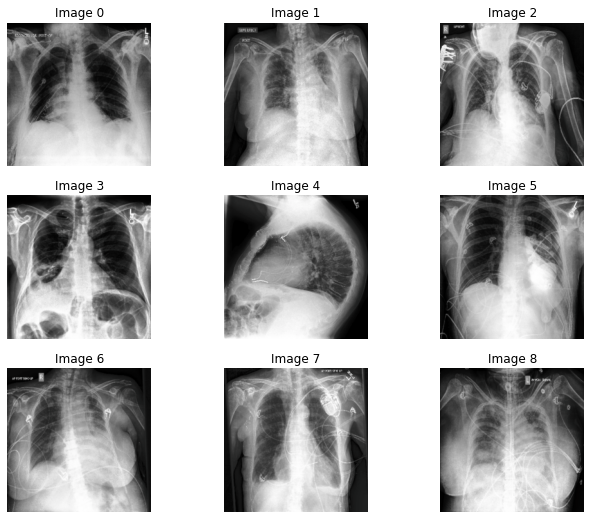

In [12]:
interp.plot_top_losses(9, figsize=(11,9))

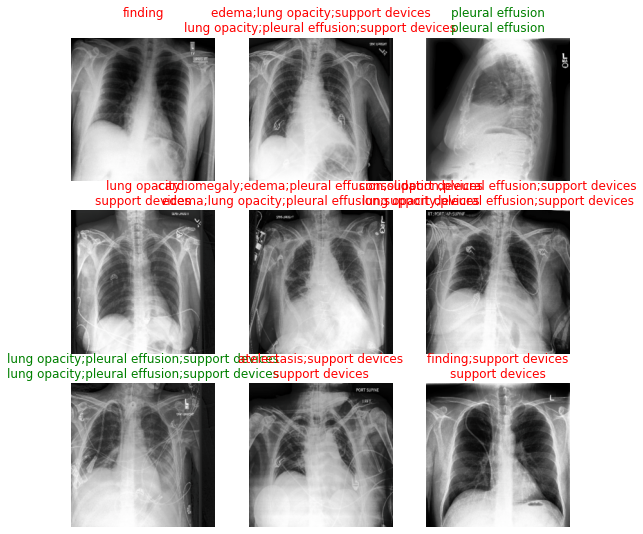

In [15]:
learn.show_results()

## 3. Distributed data parallel (4 x GPUs)

In [2]:
# ## terminal result 
# (base) jupyter@pdt:~$ python -m fastai.launch /home/jupyter/Xclassifier/xclassifier-chexpert.py
# epoch     train_loss  valid_loss  accuracy_multi  roc_auc_score  precision_score  recall_score  f1_score  time    
# 0         0.363094    0.376528    0.845413        0.617749       0.167219         0.140934      0.131623  09:41     
# epoch     train_loss  valid_loss  accuracy_multi  roc_auc_score  precision_score  recall_score  f1_score  time    
# 0         0.336456    0.461664    0.862622        0.697287       0.278177         0.176727      0.185380  04:06     
# 1         0.322720    0.103344    0.868256        0.715987       0.315141         0.188841      0.205260  04:05     
# 2         0.319125    0.641115    0.871534        0.734778       0.325251         0.208348      0.219997  04:06     
# 3         0.313709    0.137600    0.869062        0.724418       0.331341         0.194783      0.227370  04:06     
# 4         0.310645    0.107130    0.873553        0.737803       0.346044         0.190285      0.214387  04:06     
# 5         0.300463    0.111380    0.869246        0.734978       0.341621         0.200407      0.237846  04:06     
# 6         0.302023    0.890023    0.869472        0.738257       0.317800         0.215471      0.242393  04:06     
# 7         0.302866    0.921284    0.878681        0.769855       0.336663         0.251642      0.269394  04:06     
# 8         0.296317    0.804777    0.876023        0.766504       0.353870         0.210833      0.246376  04:06     
# 9         0.294123    0.135925    0.869412        0.756057       0.343822         0.248836      0.252993  04:05     